D'abord, on va importer les bibliothèques nécessaires. On utilise `numpy` pour les calculs numériques et `matplotlib.pyplot` pour la visualisation. Ensuite, on utilise `art` et `sklearn` pour les modèles de machine learning, la visualisation des données et la génération d'attaques adversariales.

In [21]:
#%pip install "numpy<2.0" scikit-learn tensorflow adversarial-robustness-toolbox --force-reinstall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from art.estimators.classification import SklearnClassifier, TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Étape 1 : Chargement et préparation des données

Dans cette première étape, nous allons charger et préparer les données pour l'analyse :

- **Chargement des données** : Les noms des colonnes sont extraits du fichier `kddcup.names` pour garantir une correspondance correcte avec le jeu de données.
- **Renommage des colonnes** : Les colonnes du DataFrame sont renommées à l'aide des noms récupérés.
- **Suppression des colonnes inutiles** : On élimine les colonnes qui n'apportent pas d'information pertinente à l'analyse.
- **Conversion des variables catégorielles** : Les colonnes de type catégoriel sont transformées en variables numériques à l'aide d'un encodage adapté (par exemple, one-hot encoding ou label encoding).

Cette étape est essentielle pour garantir la qualité des données et la performance des modèles de machine learning.

In [22]:
# Affichage des noms des colonnes
with open("./kddcup.names", 'r') as f:
    print(f.read())
    
# Affichage des noms des attaques
with open("./training_attack_types", 'r') as f:
    print(f.read())

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [23]:
# Extraction des colonnes et attaques (récupérée depuis l'article https://www.geeksforgeeks.org/intrusion-detection-system-using-machine-learning-algorithms/)
cols = """
    duration,
    protocol_type,
    service,
    flag,
    src_bytes,
    dst_bytes,
    land,
    wrong_fragment,
    urgent,
    hot,
    num_failed_logins,
    logged_in,
    num_compromised,
    root_shell,
    su_attempted,
    num_root,
    num_file_creations,
    num_shells,
    num_access_files,
    num_outbound_cmds,
    is_host_login,
    is_guest_login,
    count,
    srv_count,
    serror_rate,
    srv_serror_rate,
    rerror_rate,
    srv_rerror_rate,
    same_srv_rate,
    diff_srv_rate,
    srv_diff_host_rate,
    dst_host_count,
    dst_host_srv_count,
    dst_host_same_srv_rate,
    dst_host_diff_srv_rate,
    dst_host_same_src_port_rate,
    dst_host_srv_diff_host_rate,
    dst_host_serror_rate,
    dst_host_srv_serror_rate,
    dst_host_rerror_rate,
    dst_host_srv_rerror_rate
"""

columns =[]
for c in cols.split(',\n'):
    if(c.strip()):
       columns.append(c.strip())

columns.append('target')

#=====================================================================================#

attacks_types = {
    'normal': 'normal',
    'back': 'dos',
    'buffer_overflow': 'u2r',
    'ftp_write': 'r2l',
    'guess_passwd': 'r2l',
    'imap': 'r2l',
    'ipsweep': 'probe',
    'land': 'dos',
    'loadmodule': 'u2r',
    'multihop': 'r2l',
    'neptune': 'dos',
    'nmap': 'probe',
    'perl': 'u2r',
    'phf': 'r2l',
    'pod': 'dos',
    'portsweep': 'probe',
    'rootkit': 'u2r',
    'satan': 'probe',
    'smurf': 'dos',
    'spy': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'warezmaster': 'r2l',
}

On va générer un DataFrame à partir des données KDD Cup 1999, en utilisant les noms de colonnes et des attaques récupérées précédemment. On va également créer une colonne pour les étiquettes des attaques, en utilisant un dictionnaire pour mapper les types d'attaques aux étiquettes numériques. On va enfin encoder ces étiquettes (convertir les labels en données numériques) en utilisant `LabelEncoder` de `sklearn`.

In [24]:
path = ".\kddcup.data_10_percent.gz"

# Création du DataFrame
df = pd.read_csv(path, names = columns)

# Recodage des étiquettes de la colonne 'target'
df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
df.drop(columns=['target'], inplace=True)
df.head(20)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,1
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,1
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,1
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,1
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,1
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,1
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,1
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,1
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,1
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,1


On identifie les colonnes numériques et catégorielles, puis on normalise en utilisant `StandardScaler` de `sklearn`. On va également convertir au préalable les colonnes catégorielles en variables indicatrices (one-hot encoding) pour les utiliser dans le modèle.

In [25]:
# 1. Identifier les colonnes non numériques
non_numerical_cols = df.select_dtypes(include='object').columns
print("Colonnes non numériques :", non_numerical_cols)

# 2. Encodage des colonnes catégorielles ('protocol_type', 'service', 'flag')
df_encoded = pd.get_dummies(df, columns=non_numerical_cols)

# 3. Supprimer les colonnes avec des valeurs manquantes
df = df.dropna(axis='columns')

Colonnes non numériques : Index(['protocol_type', 'service', 'flag'], dtype='object')


## Étape 2 : Analyse exploratoire des données

Pour mieux comprendre la structure et la distribution de notre jeu de données, nous allons afficher les **statistiques descriptives** du DataFrame à l'aide de la méthode `describe()` de `pandas`.  
Cette étape permet d'obtenir rapidement des informations essentielles telles que :

- **La moyenne** (`mean`)
- **L'écart type** (`std`)
- **Les valeurs minimales et maximales** (`min`, `max`)
- **Les quartiles** (`25%`, `50%`, `75%`)

Ces statistiques sont particulièrement utiles pour détecter d'éventuelles anomalies, valeurs extrêmes ou déséquilibres dans les données, et orienter les étapes de prétraitement à venir.

In [26]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412,0.220796
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140,0.451233
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


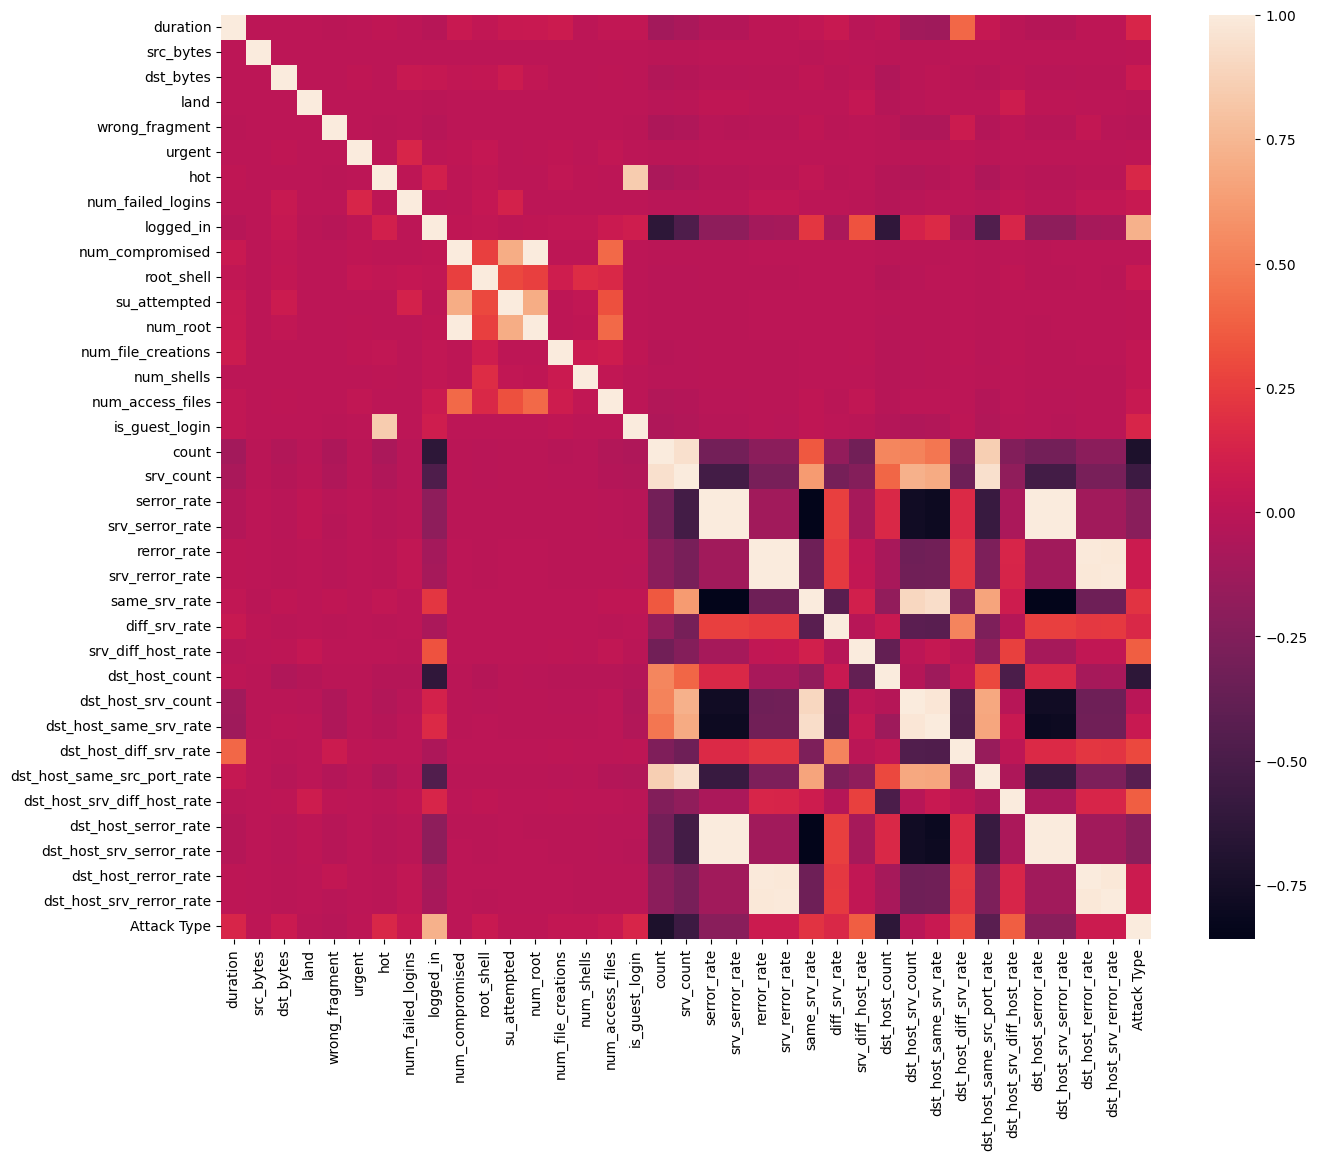

In [27]:
# On retire les colonnes avec une seule valeur unique ou non numériques
ndf = df[[col for col in df.columns if df[col].nunique() > 1 and pd.api.types.is_numeric_dtype(df[col])]]

# Calcul de la matrice de corrélation
corr = ndf.corr()

plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()

On élimine les colonnes trop corrélées pour éviter la multicolinéarité, en utilisant la méthode `corr()` de `pandas` pour calculer la matrice de corrélation et en supprimant les colonnes avec une corrélation supérieure à un seuil défini (par exemple, 0.9).

In [28]:
# Seuil de corrélation
threshold = 0.95

# Calcul de la matrice de corrélation sur les variables explicatives
corr_matrix = ndf.corr().abs()

# Sélectionner les colonnes à supprimer (une seule de chaque paire fortement corrélée)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Colonnes fortement corrélées à ignorer :", to_drop)

# Création d'un nouveau jeu de données sans ces colonnes
df_uncorr = ndf.drop(columns=to_drop)

Colonnes fortement corrélées à ignorer : ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [29]:
df_uncorr.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,Attack Type
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,0.057433,0.791547,0.020982,0.028997,232.470778,188.665670,0.030906,0.601935,0.006684,0.220796
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,0.231623,0.388189,0.082205,0.142397,64.745380,106.040437,0.109259,0.481309,0.042133,0.451233
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,0.040000,1.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,4.000000


On a remarqué que les données ne sont pas normalisées, donc on va les normaliser en utilisant `MinMaxScaler` de `sklearn`. Cela va transformer les données pour qu'elles soient comprises entre 0 et 1, ce qui est très utile pour les modèles de machine learning.

In [30]:
# Séparation features / target
X = df_uncorr.drop("Attack Type", axis=1)
y = df_uncorr["Attack Type"]

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Création du deuxième vecteur de labels binaire
y_binary = np.where(y > 0, 1, 0)

# Création des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

## Étape 3 : Entraînement du modèle

In [31]:
# Entraîner le modèle
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Créer un classifieur ART
classifier = SklearnClassifier(model=model)

# Prédictions normales
preds = classifier.predict(X_test)

# Calculer l'accuracy
accuracy = np.mean(np.argmax(preds, axis=1) == y_test)
    
print("Accuracy normale :", accuracy)

# Attaque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.05)
X_test_adv = attack.generate(x=X_test)

# Prédictions sur données attaquées
preds_adv = classifier.predict(X_test_adv)

# Calculer l'accuracy
accuracy_adv = np.mean(np.argmax(preds_adv, axis=1) == y_test)
    
print("Accuracy après attaque :", accuracy_adv)

Accuracy normale : 0.9920449369971155
Accuracy après attaque : 0.18794595415211782


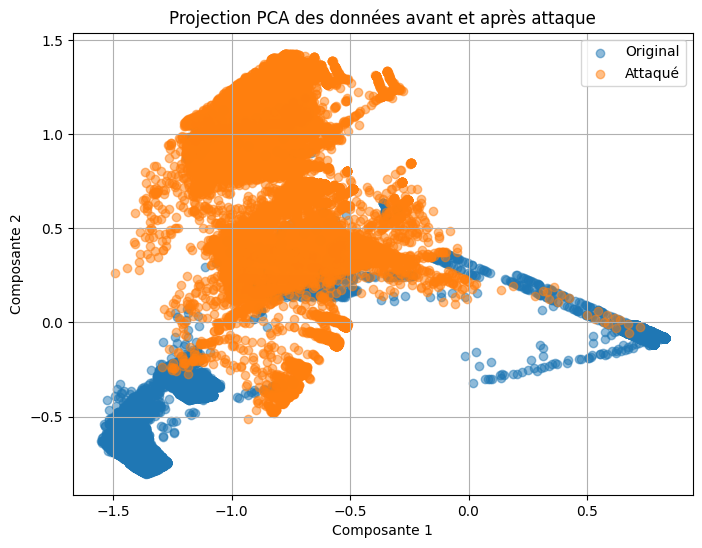

In [32]:
# Visualisation des données originales et attaquées
X_all = np.concatenate([X_test, X_test_adv])
y_all = np.concatenate([y_test, y_test])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Tracer
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0, 0], X_pca[y_all == 0, 1], label="Original", alpha=0.5)
plt.scatter(X_pca[y_all == 1, 0], X_pca[y_all == 1, 1], label="Attaqué", alpha=0.5)
plt.title("Projection PCA des données avant et après attaque")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Test avec attaque PGD
attack = ProjectedGradientDescent(estimator=classifier, eps=0.05, verbose=False)

X_adv = attack.generate(x=X_test)
preds_adv = classifier.predict(X_adv)

# Calculer l'accuracy en fonction de la forme des prédictions
acc = np.mean(np.argmax(preds_adv, axis=1) == y_test)
    
print(f"Accuracy après attaque : {acc:.5f}")

Accuracy après attaque : 0.16753


In [34]:
drop = accuracy - accuracy_adv
print("Chute de précision :", drop)

success_rate = np.mean(np.argmax(preds, axis=1) != np.argmax(preds_adv, axis=1))
print("Taux de succès de l'attaque :", success_rate)

Chute de précision : 0.8040989828449977
Taux de succès de l'attaque : 0.8389656393907191


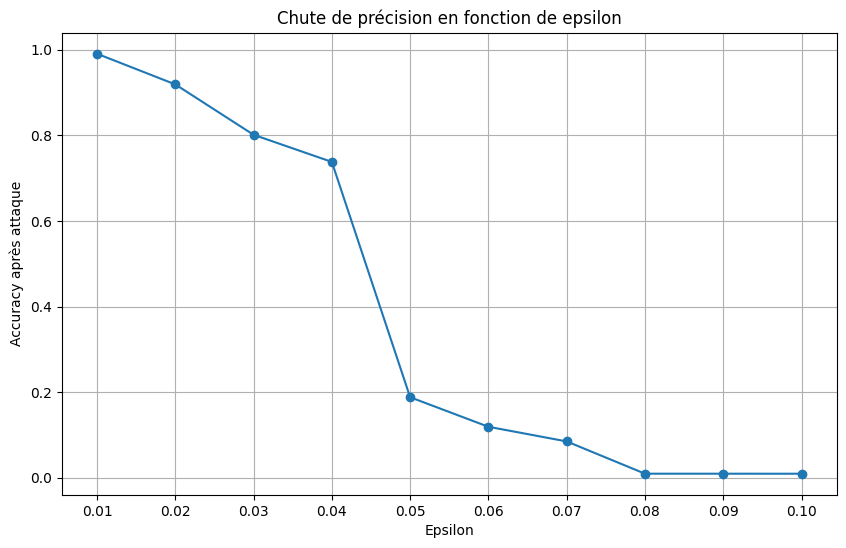

In [35]:
# Test avec plusieurs valeurs de epsilon
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
accuracies = []
for eps in epsilons:
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    X_test_adv = attack.generate(x=X_test)
    preds_adv = classifier.predict(X_test_adv)
    accuracy_adv = np.mean(np.argmax(preds_adv, axis=1) == y_test)
    accuracies.append(accuracy_adv)

# Tracer la chute de précision en fonction de epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title("Chute de précision en fonction de epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy après attaque")
plt.xticks(epsilons)
plt.grid(True)
plt.show()

In [36]:
print(accuracies)

[0.9908000607256717, 0.919113405192045, 0.8013663276149993, 0.7379080006072567, 0.18794595415211782, 0.11892110723141541, 0.08466170740347148, 0.009250544000809676, 0.009220181164920804, 0.009179697383735641]


In [37]:
num_classes = len(np.unique(y_train))

# Simple modèle Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Enveloppe ART
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(X_train.shape[1],),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer
)

# Entraîner le modèle
classifier.fit(X_train, y_train, nb_epochs=10, batch_size=32)

In [38]:
# Prédictions normales
preds = classifier.predict(X_test)

# Calculer l'accuracy
accuracy = np.mean(np.argmax(preds, axis=1) == y_test)
print("Accuracy normale :", accuracy)

# Attaque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)
X_test_adv = attack.generate(x=X_test)

# Prédictions sur données attaquées
preds_adv = classifier.predict(X_test_adv)

# Calculer l'accuracy
accuracy_adv = np.mean(np.argmax(preds_adv, axis=1) == y_test)
    
print("Accuracy après attaque :", accuracy_adv)

Accuracy normale : 0.9987854865644451
Accuracy après attaque : 0.021699306715247203


In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

GPU disponible : []


In [40]:
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)

def create_keras_model():
    # Exemple de modèle Keras simple
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 1. Crée le modèle normal
model = create_keras_model()  # à définir selon tes données
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=X_train.shape[1:],
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer
)

# 2. Entraînement normal (baseline)
classifier.fit(X_train, y_train_cat, nb_epochs=10, batch_size=32)

# 3. Évaluation du modèle normal
preds_clean = np.argmax(classifier.predict(X_test), axis=1)
acc_clean_baseline = accuracy_score(y_test, preds_clean)

# 4. Générer des exemples adversariaux
attack = FastGradientMethod(estimator=classifier, eps=0.1)
X_test_adv = attack.generate(x=X_test)

# 5. Évaluation du modèle normal sur données adversariales
preds_adv = np.argmax(classifier.predict(X_test_adv), axis=1)
acc_adv_baseline = accuracy_score(y_test, preds_adv)

# 6. Réinitialise le modèle (sinon il est déjà entraîné)
model = create_keras_model()
optimizer_adv = tf.keras.optimizers.Adam(learning_rate=0.001)  # Nouvelle instance d'optimizer
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=X_train.shape[1:],
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer_adv
)

# 7. Entraînement adversarial
trainer = AdversarialTrainer(classifier=classifier, attacks=attack, ratio=0.5)
trainer.fit(X_train, y_train_cat, nb_epochs=2, batch_size=32)

# 8. Évaluation du modèle adversarial
preds_clean_advtrained = np.argmax(classifier.predict(X_test), axis=1)
acc_clean_advtrained = accuracy_score(y_test, preds_clean_advtrained)

preds_adv_advtrained = np.argmax(classifier.predict(X_test_adv), axis=1)
acc_adv_advtrained = accuracy_score(y_test, preds_adv_advtrained)

# 9. Affichage
print(f"Modèle normal - accuracy propre      : {acc_clean_baseline:.4f}")
print(f"Modèle normal - accuracy attaqué     : {acc_adv_baseline:.4f}")
print(f"Modèle adversarial - accuracy propre : {acc_clean_advtrained:.4f}")
print(f"Modèle adversarial - accuracy attaqué: {acc_adv_advtrained:.4f}")


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Modèle normal - accuracy propre      : 0.9989
Modèle normal - accuracy attaqué     : 0.0079
Modèle adversarial - accuracy propre : 0.9981
Modèle adversarial - accuracy attaqué: 0.9988
